<a href="https://colab.research.google.com/github/muadgijo/amr-x/blob/master/Copy_of_AMR_X.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==============================================
# AMR-X XGBoost Notebook - Antibiotic Resistance
# ==============================================

# 1️⃣ SETUP - Install & import libraries
!pip install pandas matplotlib scikit-learn xgboost shap > /dev/null

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier
import shap
import joblib
from google.colab import files

print("Libraries ready!")

Libraries ready!


In [ ]:
# ==============================================
# 2️⃣ UPLOAD YOUR DATA & PREPARE
# ==============================================
print("Please upload your 'antibiotic_resistance_data.csv' file:")
uploaded = files.upload()
filename = list(uploaded.keys())[0]
data = pd.read_csv(filename)

print(f"Data loaded with {len(data)} records")
print("Columns:", list(data.columns))
print("\nFirst 3 rows:\n", data.head(3))
print("\nResistanceStatus counts:\n", data['ResistanceStatus'].value_counts())

print("\n🛠 Preparing data for modeling...")

# Identify categorical columns for one-hot encoding
categorical_cols = ['District', 'PatientGender', 'ReportedSymptom', 'DrugPrescribed', 'PatientAge']

# Drop unnecessary columns
data = data.drop(columns=['YearMonth', 'RecordID', 'ReportDate'], errors='ignore')

# Perform one-hot encoding on categorical columns
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

print("\nData after preparation:")
print(data.head())
print("\nData types after preparation:")
print(data.dtypes)

Please upload your 'antibiotic_resistance_data.csv' file:


Saving antibiotic_resistance_data.csv to antibiotic_resistance_data (6).csv
Data loaded with 2000 records
Columns: ['RecordID', 'ReportDate', 'District', 'PatientAge', 'PatientGender', 'ReportedSymptom', 'DrugPrescribed', 'PreviousTreatments', 'DaysSinceLastTreatment', 'TreatmentSuccess', 'ResistanceStatus', 'Month', 'IsWinterMonth', 'IsElderlyPatient', 'YearMonth']

First 3 rows:
    RecordID  ReportDate    District PatientAge PatientGender ReportedSymptom  \
0         1  2023-04-13  District_C      51-65          Male    GI_Infection   
1         2  2023-03-29  District_D      19-35        Female  Skin_Infection   
2         3  2023-07-11  District_D        65+          Male       Pneumonia   

  DrugPrescribed  PreviousTreatments  DaysSinceLastTreatment  \
0    Doxycycline                   0                       0   
1    Doxycycline                   0                       0   
2    Doxycycline                   1                     188   

   TreatmentSuccess  ResistanceStatus

In [ ]:
# ==============================================
# 3️⃣ DATA PREPARATION
# ==============================================
categorical_cols = ['District', 'PatientGender', 'ReportedSymptom', 'DrugPrescribed']
label_encoders = {}

for col in categorical_cols:
    if col in data.columns:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col].astype(str))
        label_encoders[col] = le

target = 'ResistanceStatus'
features = [col for col in data.columns if col not in ['RecordID', 'ReportDate', target]]

X = data[features]
y = data[target]

print(f"Using {len(features)} features: {features}")

Using 22 features: ['PreviousTreatments', 'DaysSinceLastTreatment', 'TreatmentSuccess', 'Month', 'IsWinterMonth', 'IsElderlyPatient', 'District_District_B', 'District_District_C', 'District_District_D', 'PatientGender_Male', 'ReportedSymptom_Pneumonia', 'ReportedSymptom_Respiratory_Infection', 'ReportedSymptom_Skin_Infection', 'ReportedSymptom_UTI', 'DrugPrescribed_Azithromycin', 'DrugPrescribed_Cefixime', 'DrugPrescribed_Ciprofloxacin', 'DrugPrescribed_Doxycycline', 'PatientAge_19-35', 'PatientAge_36-50', 'PatientAge_51-65', 'PatientAge_65+']


In [ ]:
# ==============================================
# 4️⃣ TRAIN/TEST SPLIT
# ==============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")
from sklearn.model_selection import train_test_split
demo_train, demo_test = train_test_split(data, test_size=0.05, random_state=42, stratify=data['ResistanceStatus'])
demo_test.to_csv("demo_test_set.csv", index=False)
files.download("demo_test_set.csv")

# ==============================================
# 5️⃣ TRAIN XGBOOST MODEL
# ==============================================
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

preds = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print(f"XGBoost Model Accuracy: {accuracy:.1%}")


Training samples: 1600, Testing samples: 400


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

XGBoost Model Accuracy: 80.0%


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:20:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


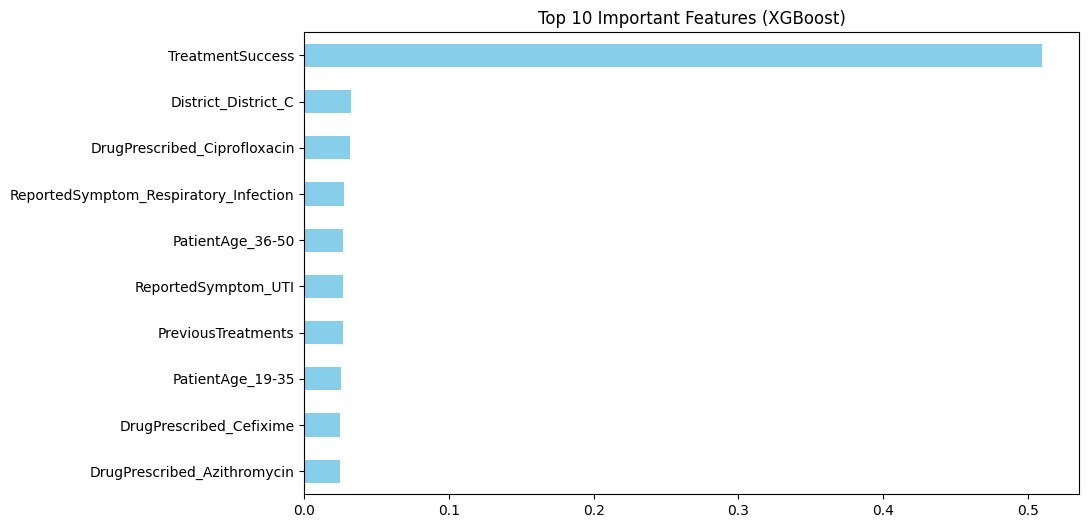

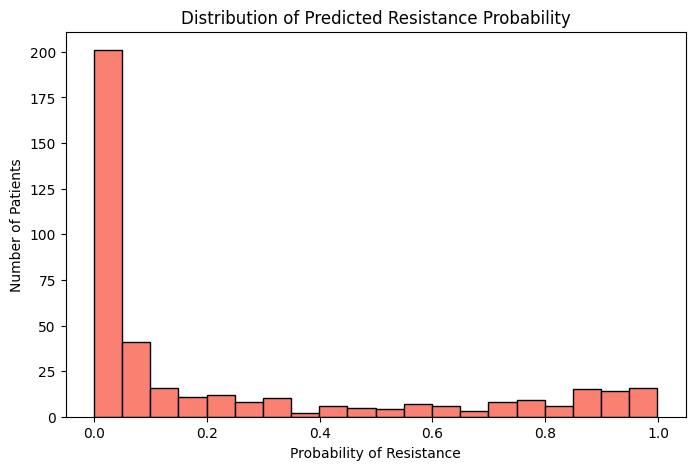

In [ ]:
# ==============================================
# 6️⃣ FEATURE IMPORTANCE PLOTS
# ==============================================
importances = pd.Series(xgb_model.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
importances.head(10).plot(kind='barh', color='skyblue')
plt.title("Top 10 Important Features (XGBoost)")
plt.gca().invert_yaxis()
plt.show()

# Histogram of predictions probability
probs = xgb_model.predict_proba(X_test)[:,1]
plt.figure(figsize=(8,5))
plt.hist(probs, bins=20, color='salmon', edgecolor='black')
plt.title("Distribution of Predicted Resistance Probability")
plt.xlabel("Probability of Resistance")
plt.ylabel("Number of Patients")
plt.show()


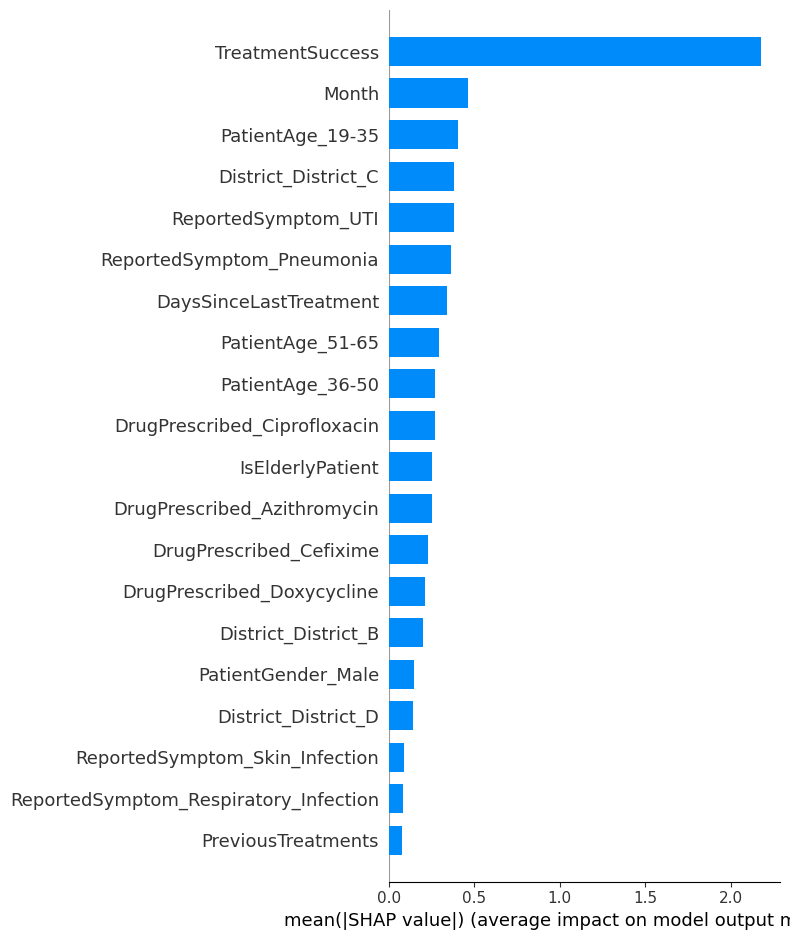

In [ ]:
# ==============================================
# 7️⃣ SHAP EXPLAINABILITY (Optional)
# ==============================================
explainer = shap.TreeExplainer(xgb_model)
sample = X_test.sample(100, random_state=42)
shap_values = explainer.shap_values(sample)
shap.summary_plot(shap_values, sample, feature_names=features, plot_type="bar")

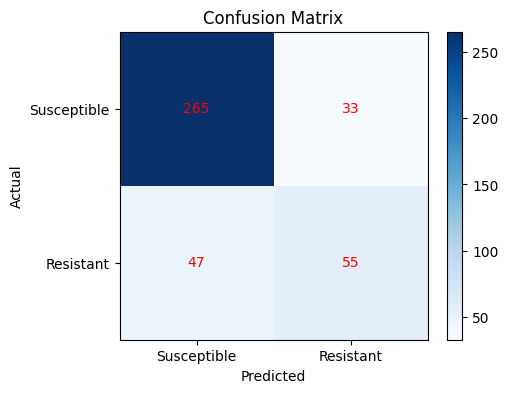

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model saved!


In [ ]:
# ==============================================
# 8️⃣ CONFUSION MATRIX
# ==============================================
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0,1], ["Susceptible", "Resistant"])
plt.yticks([0,1], ["Susceptible", "Resistant"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha='center', va='center', color='red')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# ==============================================
# 9️⃣ SAVE MODEL
# ==============================================
joblib.dump(xgb_model, "xgboost_resistance_model.pkl")
files.download("xgboost_resistance_model.pkl")
print("Model saved!")

In [ ]:
# ==============================================
# 10️⃣ PREDICTION FUNCTION FOR MULTIPLE PATIENTS
# ==============================================
def predict_resistance(records, model=xgb_model):
    df_input = pd.DataFrame(records)

    # Define categorical columns for one-hot encoding (must match training)
    categorical_cols_pred = ['District', 'PatientGender', 'ReportedSymptom', 'DrugPrescribed', 'PatientAge']

    # Drop unnecessary columns from input if they exist and are not features
    cols_to_drop_pred = ['YearMonth', 'RecordID', 'ReportDate'] # Match columns dropped during training prep
    df_input = df_input.drop(columns=[col for col in cols_to_drop_pred if col in df_input.columns], errors='ignore')


    # Apply one-hot encoding to categorical columns
    df_input_encoded = pd.get_dummies(df_input, columns=categorical_cols_pred, drop_first=True)

    # Ensure the input DataFrame has the same columns as the training data (X)
    # This is crucial because one-hot encoding can result in different columns
    # if not all categories are present in the input records.
    # Get the columns from the training data (X DataFrame)
    training_columns = X.columns.tolist()

    # Add missing columns from training data to the input, filling with 0 (appropriate for OHE)
    for col in training_columns:
        if col not in df_input_encoded.columns:
            df_input_encoded[col] = 0

    # Reindex the input DataFrame to match the order of training columns
    df_input_encoded = df_input_encoded[training_columns]

    # Ensure dtypes match training data (explicitly convert to float as done for training)
    df_input_encoded = df_input_encoded.astype(X.dtypes)


    probs = model.predict_proba(df_input_encoded)[:,1]
    outcomes = ["RESISTANT" if p>0.5 else "SUSCEPTIBLE" for p in probs]
    results = df_input.copy() # Use the original input DataFrame for results display
    results["ResistanceProbability"] = probs
    results["PredictedOutcome"] = outcomes
    return results

In [ ]:
example_patients = [
    {
        'District':'District_A','PatientAge':45,'PatientGender':'Male','ReportedSymptom':'UTI',
        'DrugPrescribed':'Amoxicillin','PreviousTreatments':2,'DaysSinceLastTreatment':30,
        'TreatmentSuccess':1,'Month':6
    },
    {
        'District':'District_B','PatientAge':60,'PatientGender':'Female','ReportedSymptom':'Respiratory',
        'DrugPrescribed':'Ceftriaxone','PreviousTreatments':3,'DaysSinceLastTreatment':15,
        'TreatmentSuccess':0,'Month':3
    }
]

pred_results = predict_resistance(example_patients)
print(pred_results)

# ==============================================
# 11️⃣ SUMMARY
# ==============================================
print("AMR-X XGBoost Demo Complete")
print(f"Model Accuracy: {accuracy:.1%}")
print("Feature importance & SHAP plots generated")
print("Confusion matrix shows true vs predicted labels")
print("Can predict multiple patients interactively")

     District  PatientAge PatientGender ReportedSymptom DrugPrescribed  \
0  District_A          45          Male             UTI    Amoxicillin   
1  District_B          60        Female     Respiratory    Ceftriaxone   

   PreviousTreatments  DaysSinceLastTreatment  TreatmentSuccess  Month  \
0                   2                      30                 1      6   
1                   3                      15                 0      3   

   ResistanceProbability PredictedOutcome  
0               0.097509      SUSCEPTIBLE  
1               0.312612      SUSCEPTIBLE  
AMR-X XGBoost Demo Complete
Model Accuracy: 80.0%
Feature importance & SHAP plots generated
Confusion matrix shows true vs predicted labels
Can predict multiple patients interactively


In [ ]:
# Load demo test set from uploaded file
# The file was saved to the current directory, not /mnt/data/
demo_patients_df = pd.read_csv("demo_test_set.csv")
print(demo_patients_df.head())

   PreviousTreatments  DaysSinceLastTreatment  TreatmentSuccess  \
0                   2                     356                 1   
1                   0                       0                 1   
2                   0                       0                 1   
3                   0                       0                 1   
4                   0                       0                 0   

   ResistanceStatus  Month  IsWinterMonth  IsElderlyPatient  \
0                 0      4              0                 1   
1                 0     10              0                 0   
2                 0      1              1                 0   
3                 0      2              1                 0   
4                 1      6              0                 0   

   District_District_B  District_District_C  District_District_D  ...  \
0                False                 True                False  ...   
1                False                 True                False  ...   

In [ ]:
# Predict resistance for uploaded demo test set
# The demo_patients_df is already one-hot encoded.
# Ensure its columns match the training data (X) before prediction.

# Get the columns from the training data (X DataFrame)
training_columns = X.columns.tolist()

# Create a copy to avoid modifying the original loaded dataframe
demo_patients_df_processed = demo_patients_df.copy()

# Add missing columns from training data to the demo data, filling with 0
for col in training_columns:
    if col not in demo_patients_df_processed.columns:
        demo_patients_df_processed[col] = 0

# Reindex the demo data DataFrame to match the order of training columns
demo_patients_df_aligned = demo_patients_df_processed[training_columns]

# Ensure dtypes match training data (explicitly convert to float as done for training)
demo_patients_df_aligned = demo_patients_df_aligned.astype(X.dtypes)


# Use the trained model directly for prediction and probability
probs = xgb_model.predict_proba(demo_patients_df_aligned)[:, 1]
preds = xgb_model.predict(demo_patients_df_aligned) # Get predicted class

outcomes = ["RESISTANT" if p > 0.5 else "SUSCEPTIBLE" for p in probs]

# Display results (add original columns and actual status for context)
results = demo_patients_df.copy() # Use the original loaded dataframe for display
results["ResistanceProbability"] = probs
results["PredictedOutcome"] = outcomes
# Assuming 'ResistanceStatus' is in the loaded demo_patients_df
if 'ResistanceStatus' in results.columns:
    results["ActualResistanceStatus"] = results['ResistanceStatus']
    cols_to_display = ['ResistanceProbability', 'PredictedOutcome', 'ActualResistanceStatus']
else:
     cols_to_display = ['ResistanceProbability', 'PredictedOutcome']

# Add some original identifying columns if they exist and are useful for context
identifying_cols = [col for col in ['RecordID', 'ReportDate'] if col in demo_patients_df.columns]
cols_to_display = identifying_cols + cols_to_display + [col for col in results.columns if col not in identifying_cols + cols_to_display]


print("Prediction Results for Loaded Demo Test Data:")
display(results[cols_to_display])

Prediction Results for Loaded Demo Test Data:


,ResistanceProbability,PredictedOutcome,ActualResistanceStatus,PreviousTreatments,DaysSinceLastTreatment,TreatmentSuccess,ResistanceStatus,Month,IsWinterMonth,IsElderlyPatient,...,ReportedSymptom_Skin_Infection,ReportedSymptom_UTI,DrugPrescribed_Azithromycin,DrugPrescribed_Cefixime,DrugPrescribed_Ciprofloxacin,DrugPrescribed_Doxycycline,PatientAge_19-35,PatientAge_36-50,PatientAge_51-65,PatientAge_65+
0,0.000318,SUSCEPTIBLE,0,2,356,1,0,4,0,1,...,False,False,False,False,True,False,False,False,False,True
1,0.051621,SUSCEPTIBLE,0,0,0,1,0,10,0,0,...,False,False,True,False,False,False,True,False,False,False
2,0.022611,SUSCEPTIBLE,0,0,0,1,0,1,1,0,...,False,False,False,False,False,False,False,False,False,False
3,0.060348,SUSCEPTIBLE,0,0,0,1,0,2,1,0,...,False,False,False,True,False,False,False,True,False,False
4,0.813783,RESISTANT,1,0,0,0,1,6,0,0,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.015152,SUSCEPTIBLE,0,1,42,1,0,2,1,0,...,False,False,False,False,False,False,False,False,False,False
96,0.878708,RESISTANT,1,0,0,0,1,4,0,0,...,False,False,False,False,True,False,False,True,False,False
97,0.040871,SUSCEPTIBLE,0,0,0,1,0,6,0,0,...,False,False,True,False,False,False,False,True,False,False
98,0.003739,SUSCEPTIBLE,0,0,0,1,0,7,0,0,...,False,False,False,True,False,False,False,False,False,False


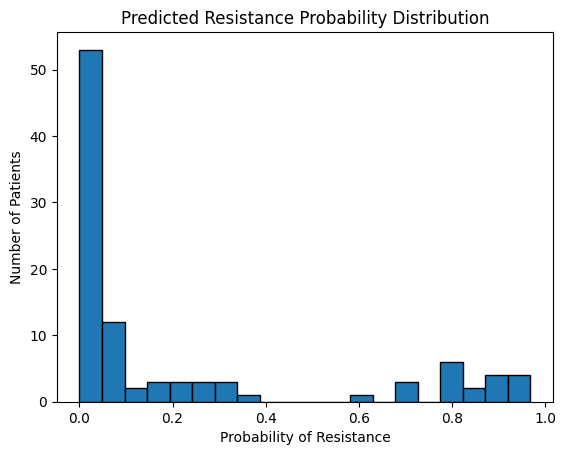

In [ ]:
# Plot distribution of predicted resistance
plt.hist(results["ResistanceProbability"], bins=20, edgecolor='black') # Changed results_df to results
plt.title("Predicted Resistance Probability Distribution")
plt.xlabel("Probability of Resistance")
plt.ylabel("Number of Patients")
plt.show()